In [3]:
import os
import math
import h5py
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

In [4]:
# exp_name = "x-pred_size-48"
# img_size = 48

exp_name = "x-pred_size-256_v2"
img_size = 256

num_epochs = 200

In [5]:
###############################
# 1) DATA LOADING & RESIZING
###############################
def load_swept_sine_case(file_path, amplitude_key, target_x=img_size, target_y=img_size):
    """Redimensionné en 48x48 pour être divisible par 16 (patch size)"""
    with h5py.File(file_path, 'r') as f:
        dataset = f['data_structure']['swept_sines'][amplitude_key]
        wz_grid = np.array(dataset['wz_grid'])  # (6405, T)
        T = wz_grid.shape[1]
        spatial_x, spatial_y = 61, 105
        wz_3d = wz_grid.reshape(spatial_x, spatial_y, T)
        u = np.array(dataset['y'])
        if u.ndim > 1:
            u = u.squeeze()
        frames_resized = np.zeros((target_x, target_y, T), dtype=np.float32)
        for t in range(T):
            frames_resized[:, :, t] = scipy.ndimage.zoom(
                wz_3d[:, :, t],
                (target_x / spatial_x, target_y / spatial_y),
                order=1
            )
        frames_resized = np.transpose(frames_resized, (2, 0, 1))  # (T, target_x, target_y)
        frames_resized = frames_resized[:, np.newaxis, :, :]      # (T, 1, target_x, target_y)
        return {
            'amplitude': amplitude_key,
            'u': u.astype(np.float32),
            'frames': frames_resized
        }

def load_all_amplitudes(file_path, amplitude_map, amplitude_list):
    data_list = []
    for amp in amplitude_list:
        amp_key = amplitude_map[amp]
        data_case = load_swept_sine_case(file_path, amp_key, target_x=img_size, target_y=img_size)
        data_list.append(data_case)
    return data_list

def split_data(file_path):
    amplitude_map = {
        0.5:  'A0p05',
        0.75: 'A0p075',
        1.0:  'A0p10',
        1.25: 'A0p125',
        1.5:  'A0p15',
        1.75: 'A0p175',
        2.0:  'A0p20',
        2.25: 'A0p225',
        2.5:  'A0p25',
        2.75: 'A0p275',
        3.0:  'A0p30'
    }
    train_amps = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
    val_amps   = [0.75, 1.75, 2.75]
    test_amps  = [1.25, 2.25]
    train_list = load_all_amplitudes(file_path, amplitude_map, train_amps)
    val_list   = load_all_amplitudes(file_path, amplitude_map, val_amps)
    test_list  = load_all_amplitudes(file_path, amplitude_map, test_amps)
    return train_list, val_list, test_list

###############################
# 1.1) NORMALISATION DES DONNÉES
###############################
def compute_normalization_stats(data_list):
    all_frames = np.concatenate([data['frames'] for data in data_list], axis=0)
    frame_mean = all_frames.mean()
    frame_std = all_frames.std()
    all_u = np.concatenate([data['u'] for data in data_list], axis=0)
    u_mean = all_u.mean()
    u_std = all_u.std()
    return frame_mean, frame_std, u_mean, u_std

def normalize_data_list(data_list, frame_mean, frame_std, u_mean, u_std):
    for data in data_list:
        data['frames'] = (data['frames'] - frame_mean) / frame_std
        data['u'] = (data['u'] - u_mean) / u_std

###############################
# 2) CREATING SEQUENCES FOR JiT
###############################
def create_jit_sequences(data_list, past_window=2, delta_t=1.0):
    """Créer des séquences pour l'entraînement avec JiT"""
    X_frames_list, X_u_past_list, X_u_curr_list, Y_list = [], [], [], []
    for data_case in data_list:
        frames = data_case['frames']  # (T, 1, H, W)
        u = data_case['u']            # (T,)
        T = frames.shape[0]
        for i in range(past_window, T):
            past_f = frames[i-past_window:i]               # (past_window, 1, H, W)
            past_u = u[i-past_window:i].reshape(-1, 1)     # (past_window, 1)
            current_u = np.array([u[i]], dtype=np.float32) # (1,)
            
            # target_f = frames[i]                           # (1, H, W)
            
            current_frame = frames[i-1]   # x(t)
            next_frame = frames[i]        # x(t+1)
            x_dot = (next_frame - current_frame) / delta_t

            
            X_frames_list.append(past_f)
            X_u_past_list.append(past_u)
            X_u_curr_list.append(current_u)
            Y_list.append(x_dot)
            
    X_frames = np.array(X_frames_list, dtype=np.float32)
    X_u_past = np.array(X_u_past_list, dtype=np.float32)
    X_u_curr = np.array(X_u_curr_list, dtype=np.float32)
    Y = np.array(Y_list, dtype=np.float32)
    return X_frames, X_u_past, X_u_curr, Y

class FluidDynamicsDataset(Dataset):
    def __init__(self, X_frames, X_u_past, X_u_curr, Y):
        self.X_frames = X_frames
        self.X_u_past = X_u_past
        self.X_u_curr = X_u_curr
        self.Y = Y
    
    def __len__(self):
        return len(self.X_frames)
    
    def __getitem__(self, idx):
        return self.X_frames[idx], self.X_u_past[idx], self.X_u_curr[idx], self.Y[idx]

In [6]:
###############################
# 3) JiT ARCHITECTURE COMPONENTS (from model_jit.py)
###############################
def get_2d_sincos_pos_embed(embed_dim, grid_size):
    """Generate 2D sin-cos positional embedding"""
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)
    grid = np.stack(grid, axis=0)
    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return pos_embed

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])
    emb = np.concatenate([emb_h, emb_w], axis=1)
    return emb

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega
    pos = pos.reshape(-1)
    out = np.einsum('m,d->md', pos, omega)
    emb_sin = np.sin(out)
    emb_cos = np.cos(out)
    emb = np.concatenate([emb_sin, emb_cos], axis=1)
    return emb

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    
    def forward(self, x):
        norm = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        return x / norm * self.weight

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

class BottleneckPatchEmbed(nn.Module):
    def __init__(self, img_size=img_size, patch_size=16, in_chans=1, pca_dim=128, embed_dim=384, bias=True):
        super().__init__()
        self.img_size = (img_size, img_size)
        self.patch_size = (patch_size, patch_size)
        self.num_patches = (img_size // patch_size) ** 2
        
        self.proj1 = nn.Conv2d(in_chans, pca_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.proj2 = nn.Conv2d(pca_dim, embed_dim, kernel_size=1, stride=1, bias=bias)
    
    def forward(self, x):
        x = self.proj2(self.proj1(x)).flatten(2).transpose(1, 2)
        return x

class TimestepEmbedder(nn.Module):
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size
    
    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32, device=t.device) / half
        )
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding
    
    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb

class ControlEmbedder(nn.Module):
    """Embed control signals (u_past and u_curr) into hidden dimension"""
    def __init__(self, past_window, hidden_size):
        super().__init__()
        # Embed past_window + 1 (past + current) control values
        self.mlp = nn.Sequential(
            nn.Linear(past_window + 1, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
        )
    
    def forward(self, u_past, u_curr):
        # u_past: (B, past_window, 1), u_curr: (B, 1)
        u_combined = torch.cat([u_past.squeeze(-1), u_curr], dim=1)  # (B, past_window + 1)
        return self.mlp(u_combined)

def scaled_dot_product_attention(query, key, value, dropout_p=0.0):
    L, S = query.size(-2), key.size(-2)
    scale_factor = 1 / math.sqrt(query.size(-1))
    attn_bias = torch.zeros(query.size(0), 1, L, S, dtype=query.dtype, device=query.device)
    
    with torch.cuda.amp.autocast(enabled=False):
        attn_weight = query.float() @ key.float().transpose(-2, -1) * scale_factor
    attn_weight += attn_bias
    attn_weight = torch.softmax(attn_weight, dim=-1)
    attn_weight = torch.dropout(attn_weight, dropout_p, train=True)
    return attn_weight @ value

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=True, qk_norm=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        
        self.q_norm = RMSNorm(head_dim) if qk_norm else nn.Identity()
        self.k_norm = RMSNorm(head_dim) if qk_norm else nn.Identity()
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
    
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        q = self.q_norm(q)
        k = self.k_norm(k)
        
        x = scaled_dot_product_attention(q, k, v, dropout_p=self.attn_drop.p if self.training else 0.)
        
        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class SwiGLUFFN(nn.Module):
    def __init__(self, dim, hidden_dim, drop=0.0, bias=True):
        super().__init__()
        hidden_dim = int(hidden_dim * 2 / 3)
        self.w12 = nn.Linear(dim, 2 * hidden_dim, bias=bias)
        self.w3 = nn.Linear(hidden_dim, dim, bias=bias)
        self.ffn_dropout = nn.Dropout(drop)
    
    def forward(self, x):
        x12 = self.w12(x)
        x1, x2 = x12.chunk(2, dim=-1)
        hidden = F.silu(x1) * x2
        return self.w3(self.ffn_dropout(hidden))

class FinalLayer(nn.Module):
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.norm_final = RMSNorm(hidden_size)
        self.linear = nn.Linear(hidden_size, patch_size * patch_size * out_channels, bias=True)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 2 * hidden_size, bias=True)
        )
    
    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x

class JiTBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, mlp_ratio=4.0, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        self.norm1 = RMSNorm(hidden_size, eps=1e-6)
        self.attn = Attention(hidden_size, num_heads=num_heads, qkv_bias=True, qk_norm=True,
                              attn_drop=attn_drop, proj_drop=proj_drop)
        self.norm2 = RMSNorm(hidden_size, eps=1e-6)
        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        self.mlp = SwiGLUFFN(hidden_size, mlp_hidden_dim, drop=proj_drop)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 6 * hidden_size, bias=True)
        )
    
    def forward(self, x, c):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim=-1)
        x = x + gate_msa.unsqueeze(1) * self.attn(modulate(self.norm1(x), shift_msa, scale_msa))
        x = x + gate_mlp.unsqueeze(1) * self.mlp(modulate(self.norm2(x), shift_mlp, scale_mlp))
        return x

###############################
# 4) JiT-BASED CONDITIONAL DIFFUSION MODEL
###############################
class JiTFluidDiffusion(nn.Module):
    def __init__( 
        self,
        img_size=img_size,
        patch_size=16,
        in_channels=1,
        past_window=10,
        hidden_size=384,
        depth=12,
        num_heads=6,
        mlp_ratio=4.0,
        bottleneck_dim=64,
        diffusion_steps=50,
        P_mean=-0.8,
        P_std=0.8,
        t_eps=0.05,
        noise_scale=1.0
    ):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.out_channels = in_channels
        self.hidden_size = hidden_size
        self.past_window = past_window
        self.timesteps = diffusion_steps
        self.P_mean = P_mean
        self.P_std = P_std
        self.t_eps = t_eps
        self.noise_scale = noise_scale
        
        # Embedders
        self.t_embedder = TimestepEmbedder(hidden_size)
        self.control_embedder = ControlEmbedder(past_window, hidden_size)
        
        # Patch embedding pour la target frame (bruitée)
        self.x_embedder = BottleneckPatchEmbed(
            img_size, patch_size, in_channels, bottleneck_dim, hidden_size, bias=True
        )
        
        # Patch embedding pour les past frames de conditionnement
        # On va concaténer past_window frames en entrée
        self.cond_embedder = BottleneckPatchEmbed(
            img_size, patch_size, past_window, bottleneck_dim, hidden_size, bias=True
        )
        
        # Positional embedding
        num_patches = self.x_embedder.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, hidden_size), requires_grad=False)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            JiTBlock(hidden_size, num_heads, mlp_ratio=mlp_ratio, attn_drop=0.0, proj_drop=0.0)
            for _ in range(depth)
        ])
        
        # Final prediction layer
        self.final_layer = FinalLayer(hidden_size, patch_size, self.out_channels)
        
        self.initialize_weights()
    
    def initialize_weights(self):
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)
        
        # Initialize pos_embed
        pos_embed = get_2d_sincos_pos_embed(
            self.pos_embed.shape[-1], 
            int(self.x_embedder.num_patches ** 0.5)
        )
        # (B, num_patches, hidden_size)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))
        
        # Initialize patch embeddings
        for embedder in [self.x_embedder, self.cond_embedder]:
            w1 = embedder.proj1.weight.data
            nn.init.xavier_uniform_(w1.view([w1.shape[0], -1]))
            w2 = embedder.proj2.weight.data
            nn.init.xavier_uniform_(w2.view([w2.shape[0], -1]))
            nn.init.constant_(embedder.proj2.bias, 0)
        
        # Zero-out adaLN modulation layers
        for block in self.blocks:
            nn.init.constant_(block.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(block.adaLN_modulation[-1].bias, 0)
        
        # Zero-out output layers
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].weight, 0)
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].bias, 0)
        nn.init.constant_(self.final_layer.linear.weight, 0)
        nn.init.constant_(self.final_layer.linear.bias, 0)
    
    def unpatchify(self, x):
        """x: (N, num_patches, patch_size**2 * C) -> imgs: (N, C, H, W)"""
        p = self.patch_size
        c = self.out_channels
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, w * p))
        return imgs
    
    def sample_t(self, n, device):
        """Sample timesteps from logit-normal distribution"""
        z = torch.randn(n, device=device) * self.P_std + self.P_mean
        return torch.sigmoid(z)
    
    def forward(self, cond_frames, cond_u_past, cond_u_curr, target_frame):
        """
        Training forward pass with x-prediction and v-loss
        cond_frames: (B, past_window, 1, H, W)
        cond_u_past: (B, past_window, 1)
        cond_u_curr: (B, 1)
        target_frame: (B, 1, H, W)
        """
        B = target_frame.size(0)
        device = target_frame.device
        
        # Sample timestep
        t = self.sample_t(B, device).view(-1, *([1] * (target_frame.ndim - 1)))
        t_flat = t.flatten()
        
        # Add noise to target frame (forward diffusion)
        e = torch.randn_like(target_frame) * self.noise_scale
        z_t = t * target_frame + (1 - t) * e
        
        # Ground truth velocity
        v = (target_frame - z_t) / (1 - t).clamp_min(self.t_eps)
        
        # Embed conditioning
        # (B, past_window, 1, H, W) -> (B, past_window, H, W)
        cond_frames_reshaped = cond_frames.squeeze(2)
        # (B, past_window, H, W) -> (B, num_patches, hidden_size)
        cond_tokens = self.cond_embedder(cond_frames_reshaped)
        
        # Embed noisy target
        x_tokens = self.x_embedder(z_t)  # (B, num_patches, hidden_size)
        
        # Combine conditioning and noisy target tokens
        # Simple approach: add them
        tokens = x_tokens + cond_tokens + self.pos_embed
        
        # Time and control embedding
        t_emb = self.t_embedder(t_flat)
        control_emb = self.control_embedder(cond_u_past, cond_u_curr)
        c = t_emb + control_emb
        
        # Transformer blocks
        for block in self.blocks:
            tokens = block(tokens, c)
        
        # Final layer predicts x directly
        x_dot_pred_tokens = self.final_layer(tokens, c)
        x_dot_pred = self.unpatchify(x_dot_pred_tokens)
        
        # Convert x_pred to v_pred for loss
        v_dot_pred = (x_dot_pred - z_t) / (1 - t).clamp_min(self.t_eps)
        
        # v-loss
        loss = F.smooth_l1_loss(v_dot_pred, v)
        
        return loss
    
    @torch.no_grad() 
    def sample(self, cond_frames, cond_u_past, cond_u_curr, num_steps=50, method='heun'):
        """
        Generate a frame using reverse diffusion
        """
        B = cond_frames.size(0)
        device = cond_frames.device
        H, W = self.img_size, self.img_size
        
        # Start from noise
        z = self.noise_scale * torch.randn(B, 1, H, W, device=device)
        
        # Timesteps
        timesteps = torch.linspace(0.0, 1.0, num_steps + 1, device=device)
        
        # Embed conditioning (constant throughout sampling)
        cond_frames_reshaped = cond_frames.squeeze(2)
        cond_tokens = self.cond_embedder(cond_frames_reshaped)
        cond_tokens = cond_tokens + self.pos_embed
        
        # Control embedding (constant)
        control_emb = self.control_embedder(cond_u_past, cond_u_curr)
        
        for i in range(num_steps):
            t_curr = timesteps[i]
            t_next = timesteps[i + 1]
            
            if method == 'euler':
                z = self._euler_step(z, t_curr, t_next, cond_tokens, control_emb)
            elif method == 'heun':
                z = self._heun_step(z, t_curr, t_next, cond_tokens, control_emb)
            else:
                raise ValueError(f"Unknown method: {method}")
        
        return z
    
    def _forward_sample(self, z, t, cond_tokens, control_emb):
        """Single forward pass during sampling"""
        B = z.size(0)
        t_scalar = t.expand(B)
        
        # Embed noisy sample
        x_tokens = self.x_embedder(z)
        tokens = x_tokens + cond_tokens
        
        # Time embedding
        t_emb = self.t_embedder(t_scalar)
        c = t_emb + control_emb
        
        # Transformer
        for block in self.blocks:
            tokens = block(tokens, c)
        
        # Predict x
        x_pred_tokens = self.final_layer(tokens, c)
        x_pred = self.unpatchify(x_pred_tokens)
        
        # Convert to velocity
        t_broadcast = t.view(-1, *([1] * (z.ndim - 1)))
        v_pred = (x_pred - z) / (1.0 - t_broadcast).clamp_min(self.t_eps)
        
        return v_pred
    
    def _euler_step(self, z, t_curr, t_next, cond_tokens, control_emb):
        v_pred = self._forward_sample(z, t_curr, cond_tokens, control_emb)
        z_next = z + (t_next - t_curr) * v_pred
        return z_next
    
    def _heun_step(self, z, t_curr, t_next, cond_tokens, control_emb):
        # First Euler step
        v_pred_curr = self._forward_sample(z, t_curr, cond_tokens, control_emb)
        z_euler = z + (t_next - t_curr) * v_pred_curr
        
        # Second evaluation
        v_pred_next = self._forward_sample(z_euler, t_next, cond_tokens, control_emb)
        
        # Heun average
        v_pred = 0.5 * (v_pred_curr + v_pred_next)
        z_next = z + (t_next - t_curr) * v_pred
        return z_next

###############################
# 5) TRAINING LOOP
###############################
def train_jit_diffusion(model, train_loader, val_loader, num_epochs, device, best_model_path, learning_rate=1e-4):
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.0)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for cond_frames, cond_u_past, cond_u_curr, target_frame in tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"
        ):
            cond_frames = cond_frames.to(device)
            cond_u_past = cond_u_past.to(device)
            cond_u_curr = cond_u_curr.to(device)
            target_frame = target_frame.to(device)
            
            optimizer.zero_grad()
            loss = model(cond_frames, cond_u_past, cond_u_curr, target_frame)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for cond_frames, cond_u_past, cond_u_curr, target_frame in tqdm(
                val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"
            ):
                cond_frames = cond_frames.to(device)
                cond_u_past = cond_u_past.to(device)
                cond_u_curr = cond_u_curr.to(device)
                target_frame = target_frame.to(device)
                
                loss = model(cond_frames, cond_u_past, cond_u_curr, target_frame)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {scheduler.get_last_lr()[0]:.7f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"✓ New best model saved! Val Loss: {best_val_loss:.6f}")
    
    print("\n✅ Training complete!")

###############################
# 6) AUTOREGRESSIVE EVALUATION
###############################
@torch.no_grad()
def evaluate_autoregressive(
    model,
    data_case,
    past_window,
    device,
    num_frames,
    frame_mean,
    frame_std,
    num_steps=50,
    delta_t=1.0
):
    model.eval()

    frames = data_case['frames']  # (T, 1, H, W)
    u = data_case['u']
    T = frames.shape[0]

    # initial history: x(t-past_window) ... x(t)
    history_frames = frames[:past_window].copy()

    pred_frames = []
    mse_list = []

    for i in range(num_frames):
        t_idx = past_window + i
        if t_idx >= T:
            break

        # conditioning
        cond_frames = history_frames[-past_window:]
        cond_u_past = u[t_idx - past_window:t_idx].reshape(-1, 1)
        cond_u_curr = np.array([u[t_idx]], dtype=np.float32)

        # to torch
        cond_frames_tensor = torch.tensor(
            cond_frames, dtype=torch.float32, device=device
        ).unsqueeze(0)
        past_u_tensor = torch.tensor(
            cond_u_past, dtype=torch.float32, device=device
        ).unsqueeze(0)
        curr_u_tensor = torch.tensor(
            cond_u_curr, dtype=torch.float32, device=device
        ).unsqueeze(0)

        # ---- DIFFUSION: sample x_dot ----
        x_dot = model.sample(
            cond_frames_tensor,
            past_u_tensor,
            curr_u_tensor,
            num_steps=num_steps,
            method="heun",
        )

        # torch -> numpy
        x_dot_np = x_dot.squeeze(0).cpu().numpy()  # (1, H, W)

        # ---- SOLVER (Euler) ----
        x_curr = history_frames[-1]                # (1, H, W)
        x_next = x_curr + delta_t * x_dot_np       # (1, H, W)

        # store
        pred_frames.append(x_next)

        # MSE
        true_frame = frames[t_idx]
        mse = np.mean((x_next - true_frame) ** 2)
        mse_list.append(mse)

        # update history
        history_frames = np.concatenate(
            [history_frames, x_next[np.newaxis]],
            axis=0
        )
        history_frames = history_frames[-past_window:]

    pred_frames = np.array(pred_frames)
    true_frames = frames[past_window:past_window + len(pred_frames)]

    # denormalize
    pred_frames_denorm = pred_frames * frame_std + frame_mean
    true_frames_denorm = true_frames * frame_std + frame_mean

    avg_mse = float(np.mean(mse_list))
    print(f"Average MSE for amplitude {data_case['amplitude']}: {avg_mse:.6f}")

    return pred_frames_denorm, true_frames_denorm, avg_mse

###############################
# 7) VISUALIZATION
###############################
def create_comparison_video(gt_frames, pred_frames, amplitude, save_path):
    T = gt_frames.shape[0]
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Amplitude: {amplitude}")
    ax1, ax2 = axes
    ax1.set_title("Ground Truth")
    ax2.set_title("Predicted (JiT)")
    
    vmin = min(gt_frames.min(), pred_frames.min())
    vmax = max(gt_frames.max(), pred_frames.max())
    
    sns.heatmap(gt_frames[0], cmap="magma", vmin=vmin, vmax=vmax, center=0, ax=ax1, cbar=False, square=True)
    sns.heatmap(pred_frames[0], cmap="magma", vmin=vmin, vmax=vmax, center=0, ax=ax2, cbar=False, square=True)
    
    def update(frame):
        ax1.clear()
        ax2.clear()
        sns.heatmap(gt_frames[frame], cmap="magma", vmin=vmin, vmax=vmax, center=0, ax=ax1, cbar=False, square=True)
        sns.heatmap(pred_frames[frame], cmap="magma", vmin=vmin, vmax=vmax, center=0, ax=ax2, cbar=False, square=True)
        ax1.set_title(f"Ground Truth (Frame {frame+1}/{T})")
        ax2.set_title(f"Predicted JiT (Frame {frame+1}/{T})")
    
    ani = animation.FuncAnimation(fig, update, frames=T, interval=200)
    ani.save(save_path, writer="ffmpeg", fps=5, dpi=200)
    print(f"Video saved: {save_path}")
    return save_path

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Using device: {device}")

file_path = "/home/nkhaous/myLLF/JiT_SysId/data/oscillating_cylinder_benchmark_dataset_v2.mat"

if not os.path.exists(file_path):
    print(f"❌ File not found: {file_path}")
    for root, dirs, files in os.walk("/kaggle/input"):
        for file in files:
            print(os.path.join(root, file))
    exit()

print(f"✓ File found: {file_path}")

# Load data
print("\n=== Loading data ===")
train_list, val_list, test_list = split_data(file_path)
print(f"Train: {len(train_list)}, Val: {len(val_list)}, Test: {len(test_list)}")

# Normalize
print("\n=== Normalization ===")
frame_mean, frame_std, u_mean, u_std = compute_normalization_stats(train_list)
print(f"Frame: μ={frame_mean:.6f}, σ={frame_std:.6f}")
print(f"Control u: μ={u_mean:.6f}, σ={u_std:.6f}")

normalize_data_list(train_list, frame_mean, frame_std, u_mean, u_std)
normalize_data_list(val_list, frame_mean, frame_std, u_mean, u_std)
normalize_data_list(test_list, frame_mean, frame_std, u_mean, u_std)

# Create sequences
print("\n=== Creating sequences ===")
past_window = 10
X_train_frames, X_train_u_past, X_train_u_curr, Y_train = create_jit_sequences(train_list, past_window)
X_val_frames, X_val_u_past, X_val_u_curr, Y_val = create_jit_sequences(val_list, past_window)
print(f"Train sequences: {X_train_frames.shape[0]}, Val sequences: {X_val_frames.shape[0]}")

# DataLoaders
train_dataset = FluidDynamicsDataset(X_train_frames, X_train_u_past, X_train_u_curr, Y_train)
val_dataset = FluidDynamicsDataset(X_val_frames, X_val_u_past, X_val_u_curr, Y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

🚀 Using device: cuda
✓ File found: /home/nkhaous/myLLF/JiT_SysId/data/oscillating_cylinder_benchmark_dataset_v2.mat

=== Loading data ===
Train: 6, Val: 3, Test: 2

=== Normalization ===
Frame: μ=0.001842, σ=14.864110
Control u: μ=-0.000000, σ=0.012448

=== Creating sequences ===
Train sequences: 9060, Val sequences: 4530


In [ ]:
# Create model
print("\n=== Creating JiT model ===")
model = JiTFluidDiffusion(
    img_size=img_size,
    patch_size=16,
    in_channels=1,
    past_window=past_window,
    hidden_size=384,
    depth=12,
    num_heads=6,
    mlp_ratio=4.0,
    bottleneck_dim=64,
    diffusion_steps=50,
    P_mean=-0.8,
    P_std=0.8,
    t_eps=0.05,
    noise_scale=1.0
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Train
print("\n=== Training JiT Fluid Diffusion ===")

models_path = f"output/exp_{exp_name}/models"
os.makedirs(models_path, exist_ok=True)

# train_jit_diffusion(model, 
#                     train_loader, 
#                     val_loader, 
#                     num_epochs, 
#                     device, 
#                     best_model_path=os.path.join(models_path, "best_jit_fluid_model.pth"),
#                     learning_rate=2e-4)


=== Creating JiT model ===


Total parameters: 33,058,560
Trainable parameters: 32,960,256

=== Training JiT Fluid Diffusion ===


Epoch 1/200 [Train]:   0%|          | 0/284 [00:00<?, ?it/s]/tmp/ipykernel_62456/2272590712.py:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
Epoch 1/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.51it/s]


Epoch 1/200 | Train Loss: 0.021343 | Val Loss: 0.005521 | LR: 0.0002000
✓ New best model saved! Val Loss: 0.005521


Epoch 2/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.39it/s]


Epoch 2/200 | Train Loss: 0.002843 | Val Loss: 0.001925 | LR: 0.0002000
✓ New best model saved! Val Loss: 0.001925


Epoch 3/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.33it/s]


Epoch 3/200 | Train Loss: 0.001654 | Val Loss: 0.002141 | LR: 0.0001999


Epoch 4/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.34it/s]


Epoch 4/200 | Train Loss: 0.001065 | Val Loss: 0.000982 | LR: 0.0001998
✓ New best model saved! Val Loss: 0.000982


Epoch 5/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.36it/s]


Epoch 5/200 | Train Loss: 0.000872 | Val Loss: 0.000608 | LR: 0.0001997
✓ New best model saved! Val Loss: 0.000608


Epoch 6/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.28it/s]


Epoch 6/200 | Train Loss: 0.000694 | Val Loss: 0.000500 | LR: 0.0001996
✓ New best model saved! Val Loss: 0.000500


Epoch 7/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.35it/s]


Epoch 7/200 | Train Loss: 0.000618 | Val Loss: 0.000477 | LR: 0.0001994
✓ New best model saved! Val Loss: 0.000477


Epoch 8/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.36it/s]


Epoch 8/200 | Train Loss: 0.000490 | Val Loss: 0.000698 | LR: 0.0001992


Epoch 9/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.34it/s]


Epoch 9/200 | Train Loss: 0.000442 | Val Loss: 0.000580 | LR: 0.0001990


Epoch 10/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.33it/s]


Epoch 10/200 | Train Loss: 0.000449 | Val Loss: 0.000884 | LR: 0.0001988


Epoch 11/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.34it/s]


Epoch 11/200 | Train Loss: 0.000349 | Val Loss: 0.000342 | LR: 0.0001985
✓ New best model saved! Val Loss: 0.000342


Epoch 12/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.36it/s]


Epoch 12/200 | Train Loss: 0.000324 | Val Loss: 0.000366 | LR: 0.0001982


Epoch 13/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.27it/s]


Epoch 13/200 | Train Loss: 0.000350 | Val Loss: 0.000316 | LR: 0.0001979
✓ New best model saved! Val Loss: 0.000316


Epoch 14/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.32it/s]


Epoch 14/200 | Train Loss: 0.000302 | Val Loss: 0.000436 | LR: 0.0001976


Epoch 15/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.31it/s]


Epoch 15/200 | Train Loss: 0.000244 | Val Loss: 0.000292 | LR: 0.0001973
✓ New best model saved! Val Loss: 0.000292


Epoch 16/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.35it/s]


Epoch 16/200 | Train Loss: 0.000244 | Val Loss: 0.000243 | LR: 0.0001969
✓ New best model saved! Val Loss: 0.000243


Epoch 17/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.28it/s]


Epoch 17/200 | Train Loss: 0.000269 | Val Loss: 0.000330 | LR: 0.0001965


Epoch 18/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.30it/s]


Epoch 18/200 | Train Loss: 0.000219 | Val Loss: 0.000200 | LR: 0.0001960
✓ New best model saved! Val Loss: 0.000200


Epoch 19/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.28it/s]


Epoch 19/200 | Train Loss: 0.000252 | Val Loss: 0.000177 | LR: 0.0001956
✓ New best model saved! Val Loss: 0.000177


Epoch 20/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.24it/s]


Epoch 20/200 | Train Loss: 0.000218 | Val Loss: 0.000222 | LR: 0.0001951


Epoch 21/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.34it/s]


Epoch 21/200 | Train Loss: 0.000194 | Val Loss: 0.000300 | LR: 0.0001946


Epoch 22/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.27it/s]


Epoch 22/200 | Train Loss: 0.000207 | Val Loss: 0.000146 | LR: 0.0001941
✓ New best model saved! Val Loss: 0.000146


Epoch 23/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.30it/s]


Epoch 23/200 | Train Loss: 0.000190 | Val Loss: 0.000156 | LR: 0.0001936


Epoch 24/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.36it/s]


Epoch 24/200 | Train Loss: 0.000182 | Val Loss: 0.000221 | LR: 0.0001930


Epoch 25/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.31it/s]


Epoch 25/200 | Train Loss: 0.000200 | Val Loss: 0.000158 | LR: 0.0001924


Epoch 26/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.37it/s]


Epoch 26/200 | Train Loss: 0.000144 | Val Loss: 0.000230 | LR: 0.0001918


Epoch 27/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.39it/s]


Epoch 27/200 | Train Loss: 0.000141 | Val Loss: 0.000753 | LR: 0.0001912


Epoch 28/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.29it/s]


Epoch 28/200 | Train Loss: 0.000218 | Val Loss: 0.000164 | LR: 0.0001905


Epoch 29/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.29it/s]


Epoch 29/200 | Train Loss: 0.000138 | Val Loss: 0.000117 | LR: 0.0001899
✓ New best model saved! Val Loss: 0.000117


Epoch 30/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.38it/s]


Epoch 30/200 | Train Loss: 0.000140 | Val Loss: 0.000103 | LR: 0.0001892
✓ New best model saved! Val Loss: 0.000103


Epoch 31/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.34it/s]


Epoch 31/200 | Train Loss: 0.000158 | Val Loss: 0.000122 | LR: 0.0001884


Epoch 32/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.28it/s]


Epoch 32/200 | Train Loss: 0.000135 | Val Loss: 0.000120 | LR: 0.0001877


Epoch 33/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.36it/s]


Epoch 33/200 | Train Loss: 0.000136 | Val Loss: 0.000179 | LR: 0.0001869


Epoch 34/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.37it/s]


Epoch 34/200 | Train Loss: 0.000136 | Val Loss: 0.000127 | LR: 0.0001861


Epoch 35/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.32it/s]


Epoch 35/200 | Train Loss: 0.000124 | Val Loss: 0.000123 | LR: 0.0001853


Epoch 36/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.27it/s]


Epoch 36/200 | Train Loss: 0.000126 | Val Loss: 0.000101 | LR: 0.0001845
✓ New best model saved! Val Loss: 0.000101


Epoch 37/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.35it/s]


Epoch 37/200 | Train Loss: 0.000132 | Val Loss: 0.000113 | LR: 0.0001837


Epoch 38/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.35it/s]


Epoch 38/200 | Train Loss: 0.000127 | Val Loss: 0.000145 | LR: 0.0001828


Epoch 39/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.31it/s]


Epoch 39/200 | Train Loss: 0.000102 | Val Loss: 0.000282 | LR: 0.0001819


Epoch 40/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.30it/s]


Epoch 40/200 | Train Loss: 0.000145 | Val Loss: 0.000066 | LR: 0.0001810
✓ New best model saved! Val Loss: 0.000066


Epoch 41/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.27it/s]


Epoch 41/200 | Train Loss: 0.000114 | Val Loss: 0.000108 | LR: 0.0001801


Epoch 42/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.28it/s]


Epoch 42/200 | Train Loss: 0.000097 | Val Loss: 0.000102 | LR: 0.0001791


Epoch 43/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.31it/s]


Epoch 43/200 | Train Loss: 0.000107 | Val Loss: 0.000161 | LR: 0.0001782


Epoch 44/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.34it/s]


Epoch 44/200 | Train Loss: 0.000092 | Val Loss: 0.000098 | LR: 0.0001772


Epoch 45/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.34it/s]


Epoch 45/200 | Train Loss: 0.000128 | Val Loss: 0.000103 | LR: 0.0001762


Epoch 46/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.36it/s]


Epoch 46/200 | Train Loss: 0.000099 | Val Loss: 0.000282 | LR: 0.0001751


Epoch 47/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.37it/s]


Epoch 47/200 | Train Loss: 0.000096 | Val Loss: 0.000185 | LR: 0.0001741


Epoch 48/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.39it/s]


Epoch 48/200 | Train Loss: 0.000101 | Val Loss: 0.000114 | LR: 0.0001730


Epoch 49/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.37it/s]


Epoch 49/200 | Train Loss: 0.000139 | Val Loss: 0.000100 | LR: 0.0001720


Epoch 50/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.37it/s]


Epoch 50/200 | Train Loss: 0.000080 | Val Loss: 0.000063 | LR: 0.0001709
✓ New best model saved! Val Loss: 0.000063


Epoch 51/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.34it/s]


Epoch 51/200 | Train Loss: 0.000099 | Val Loss: 0.000122 | LR: 0.0001697


Epoch 52/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.37it/s]


Epoch 52/200 | Train Loss: 0.000073 | Val Loss: 0.000092 | LR: 0.0001686


Epoch 53/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.28it/s]


Epoch 53/200 | Train Loss: 0.000091 | Val Loss: 0.000078 | LR: 0.0001675


Epoch 54/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.37it/s]


Epoch 54/200 | Train Loss: 0.000075 | Val Loss: 0.000109 | LR: 0.0001663


Epoch 55/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.27it/s]


Epoch 55/200 | Train Loss: 0.000066 | Val Loss: 0.000072 | LR: 0.0001651


Epoch 56/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.34it/s]


Epoch 56/200 | Train Loss: 0.000073 | Val Loss: 0.000071 | LR: 0.0001639


Epoch 57/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.34it/s]


Epoch 57/200 | Train Loss: 0.000085 | Val Loss: 0.000078 | LR: 0.0001627


Epoch 58/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.35it/s]


Epoch 58/200 | Train Loss: 0.000075 | Val Loss: 0.000105 | LR: 0.0001615


Epoch 59/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.32it/s]


Epoch 59/200 | Train Loss: 0.000073 | Val Loss: 0.000066 | LR: 0.0001602


Epoch 60/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.26it/s]


Epoch 60/200 | Train Loss: 0.000068 | Val Loss: 0.000094 | LR: 0.0001590


Epoch 61/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.29it/s]


Epoch 61/200 | Train Loss: 0.000059 | Val Loss: 0.000074 | LR: 0.0001577


Epoch 62/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.33it/s]


Epoch 62/200 | Train Loss: 0.000066 | Val Loss: 0.000066 | LR: 0.0001564


Epoch 63/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.29it/s]


Epoch 63/200 | Train Loss: 0.000059 | Val Loss: 0.000052 | LR: 0.0001551
✓ New best model saved! Val Loss: 0.000052


Epoch 64/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.22it/s]


Epoch 64/200 | Train Loss: 0.000065 | Val Loss: 0.000059 | LR: 0.0001538


Epoch 65/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.28it/s]


Epoch 65/200 | Train Loss: 0.000054 | Val Loss: 0.000072 | LR: 0.0001525


Epoch 66/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.26it/s]


Epoch 66/200 | Train Loss: 0.000056 | Val Loss: 0.000059 | LR: 0.0001511


Epoch 67/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.29it/s]


Epoch 67/200 | Train Loss: 0.000062 | Val Loss: 0.000060 | LR: 0.0001498


Epoch 68/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.44it/s]


Epoch 68/200 | Train Loss: 0.000058 | Val Loss: 0.000099 | LR: 0.0001484


Epoch 69/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.43it/s]


Epoch 69/200 | Train Loss: 0.000053 | Val Loss: 0.000061 | LR: 0.0001471


Epoch 70/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.34it/s]


Epoch 70/200 | Train Loss: 0.000053 | Val Loss: 0.000124 | LR: 0.0001457


Epoch 71/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.41it/s]


Epoch 71/200 | Train Loss: 0.000068 | Val Loss: 0.000078 | LR: 0.0001443


Epoch 72/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.40it/s]


Epoch 72/200 | Train Loss: 0.000049 | Val Loss: 0.000043 | LR: 0.0001429
✓ New best model saved! Val Loss: 0.000043


Epoch 73/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.34it/s]


Epoch 73/200 | Train Loss: 0.000051 | Val Loss: 0.000051 | LR: 0.0001414


Epoch 74/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.39it/s]


Epoch 74/200 | Train Loss: 0.000048 | Val Loss: 0.000051 | LR: 0.0001400


Epoch 75/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.38it/s]


Epoch 75/200 | Train Loss: 0.000047 | Val Loss: 0.000051 | LR: 0.0001386


Epoch 76/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.34it/s]


Epoch 76/200 | Train Loss: 0.000044 | Val Loss: 0.000053 | LR: 0.0001371


Epoch 77/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.35it/s]


Epoch 77/200 | Train Loss: 0.000061 | Val Loss: 0.000049 | LR: 0.0001357


Epoch 78/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.30it/s]


Epoch 78/200 | Train Loss: 0.000045 | Val Loss: 0.000047 | LR: 0.0001342


Epoch 79/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.32it/s]


Epoch 79/200 | Train Loss: 0.000044 | Val Loss: 0.000042 | LR: 0.0001327
✓ New best model saved! Val Loss: 0.000042


Epoch 80/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.26it/s]


Epoch 80/200 | Train Loss: 0.000043 | Val Loss: 0.000119 | LR: 0.0001312


Epoch 81/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.34it/s]


Epoch 81/200 | Train Loss: 0.000061 | Val Loss: 0.000037 | LR: 0.0001298
✓ New best model saved! Val Loss: 0.000037


Epoch 82/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.30it/s]


Epoch 82/200 | Train Loss: 0.000046 | Val Loss: 0.000046 | LR: 0.0001283


Epoch 83/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.32it/s]


Epoch 83/200 | Train Loss: 0.000041 | Val Loss: 0.000041 | LR: 0.0001268


Epoch 84/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.33it/s]


Epoch 84/200 | Train Loss: 0.000041 | Val Loss: 0.000050 | LR: 0.0001252


Epoch 85/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.34it/s]


Epoch 85/200 | Train Loss: 0.000036 | Val Loss: 0.000038 | LR: 0.0001237


Epoch 86/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.35it/s]


Epoch 86/200 | Train Loss: 0.000048 | Val Loss: 0.000034 | LR: 0.0001222
✓ New best model saved! Val Loss: 0.000034


Epoch 87/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.30it/s]


Epoch 87/200 | Train Loss: 0.000040 | Val Loss: 0.000035 | LR: 0.0001207


Epoch 88/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.29it/s]


Epoch 88/200 | Train Loss: 0.000037 | Val Loss: 0.000059 | LR: 0.0001191


Epoch 89/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.43it/s]


Epoch 89/200 | Train Loss: 0.000041 | Val Loss: 0.000038 | LR: 0.0001176


Epoch 90/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.32it/s]


Epoch 90/200 | Train Loss: 0.000033 | Val Loss: 0.000041 | LR: 0.0001161


Epoch 91/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.32it/s]


Epoch 91/200 | Train Loss: 0.000036 | Val Loss: 0.000026 | LR: 0.0001145
✓ New best model saved! Val Loss: 0.000026


Epoch 92/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.36it/s]


Epoch 92/200 | Train Loss: 0.000032 | Val Loss: 0.000026 | LR: 0.0001130


Epoch 93/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.38it/s]


Epoch 93/200 | Train Loss: 0.000031 | Val Loss: 0.000030 | LR: 0.0001114


Epoch 94/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.33it/s]


Epoch 94/200 | Train Loss: 0.000035 | Val Loss: 0.000027 | LR: 0.0001099


Epoch 95/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.33it/s]


Epoch 95/200 | Train Loss: 0.000032 | Val Loss: 0.000029 | LR: 0.0001083


Epoch 96/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.38it/s]


Epoch 96/200 | Train Loss: 0.000030 | Val Loss: 0.000031 | LR: 0.0001067


Epoch 97/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.32it/s]


Epoch 97/200 | Train Loss: 0.000035 | Val Loss: 0.000078 | LR: 0.0001052


Epoch 98/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.31it/s]


Epoch 98/200 | Train Loss: 0.000037 | Val Loss: 0.000032 | LR: 0.0001036


Epoch 99/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.24it/s]


Epoch 99/200 | Train Loss: 0.000031 | Val Loss: 0.000035 | LR: 0.0001021


Epoch 100/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.27it/s]


Epoch 100/200 | Train Loss: 0.000029 | Val Loss: 0.000028 | LR: 0.0001005


Epoch 101/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.34it/s]


Epoch 101/200 | Train Loss: 0.000030 | Val Loss: 0.000033 | LR: 0.0000989


Epoch 102/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.24it/s]


Epoch 102/200 | Train Loss: 0.000031 | Val Loss: 0.000031 | LR: 0.0000974


Epoch 103/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.29it/s]


Epoch 103/200 | Train Loss: 0.000031 | Val Loss: 0.000044 | LR: 0.0000958


Epoch 104/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.30it/s]


Epoch 104/200 | Train Loss: 0.000028 | Val Loss: 0.000027 | LR: 0.0000943


Epoch 105/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.31it/s]


Epoch 105/200 | Train Loss: 0.000032 | Val Loss: 0.000026 | LR: 0.0000927
✓ New best model saved! Val Loss: 0.000026


Epoch 106/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.34it/s]


Epoch 106/200 | Train Loss: 0.000025 | Val Loss: 0.000034 | LR: 0.0000911


Epoch 107/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.32it/s]


Epoch 107/200 | Train Loss: 0.000026 | Val Loss: 0.000030 | LR: 0.0000896


Epoch 108/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.31it/s]


Epoch 108/200 | Train Loss: 0.000027 | Val Loss: 0.000026 | LR: 0.0000880


Epoch 109/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.31it/s]


Epoch 109/200 | Train Loss: 0.000025 | Val Loss: 0.000024 | LR: 0.0000865
✓ New best model saved! Val Loss: 0.000024


Epoch 110/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.32it/s]


Epoch 110/200 | Train Loss: 0.000027 | Val Loss: 0.000023 | LR: 0.0000849
✓ New best model saved! Val Loss: 0.000023


Epoch 111/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.28it/s]


Epoch 111/200 | Train Loss: 0.000024 | Val Loss: 0.000027 | LR: 0.0000834


Epoch 112/200 [Val]: 100%|██████████| 142/142 [00:10<00:00, 14.15it/s]


Epoch 112/200 | Train Loss: 0.000025 | Val Loss: 0.000026 | LR: 0.0000819


Epoch 113/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.34it/s]


Epoch 113/200 | Train Loss: 0.000027 | Val Loss: 0.000027 | LR: 0.0000803


Epoch 114/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.31it/s]


Epoch 114/200 | Train Loss: 0.000024 | Val Loss: 0.000024 | LR: 0.0000788


Epoch 115/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.26it/s]


Epoch 115/200 | Train Loss: 0.000025 | Val Loss: 0.000028 | LR: 0.0000773


Epoch 116/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.37it/s]


Epoch 116/200 | Train Loss: 0.000023 | Val Loss: 0.000025 | LR: 0.0000758


Epoch 117/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.32it/s]


Epoch 117/200 | Train Loss: 0.000022 | Val Loss: 0.000028 | LR: 0.0000742


Epoch 118/200 [Val]: 100%|██████████| 142/142 [00:10<00:00, 14.20it/s]


Epoch 118/200 | Train Loss: 0.000023 | Val Loss: 0.000023 | LR: 0.0000727
✓ New best model saved! Val Loss: 0.000023


Epoch 119/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.30it/s]


Epoch 119/200 | Train Loss: 0.000020 | Val Loss: 0.000020 | LR: 0.0000712
✓ New best model saved! Val Loss: 0.000020


Epoch 120/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.27it/s]


Epoch 120/200 | Train Loss: 0.000020 | Val Loss: 0.000020 | LR: 0.0000698
✓ New best model saved! Val Loss: 0.000020


Epoch 121/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.27it/s]


Epoch 121/200 | Train Loss: 0.000020 | Val Loss: 0.000031 | LR: 0.0000683


Epoch 122/200 [Val]: 100%|██████████| 142/142 [00:10<00:00, 14.19it/s]


Epoch 122/200 | Train Loss: 0.000022 | Val Loss: 0.000020 | LR: 0.0000668


Epoch 123/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.26it/s]


Epoch 123/200 | Train Loss: 0.000021 | Val Loss: 0.000024 | LR: 0.0000653


Epoch 124/200 [Val]: 100%|██████████| 142/142 [00:10<00:00, 14.17it/s]


Epoch 124/200 | Train Loss: 0.000022 | Val Loss: 0.000019 | LR: 0.0000639
✓ New best model saved! Val Loss: 0.000019


Epoch 125/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.27it/s]


Epoch 125/200 | Train Loss: 0.000020 | Val Loss: 0.000023 | LR: 0.0000624


Epoch 126/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.30it/s]


Epoch 126/200 | Train Loss: 0.000020 | Val Loss: 0.000035 | LR: 0.0000610


Epoch 127/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.42it/s]


Epoch 127/200 | Train Loss: 0.000019 | Val Loss: 0.000020 | LR: 0.0000596


Epoch 128/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.25it/s]


Epoch 128/200 | Train Loss: 0.000018 | Val Loss: 0.000024 | LR: 0.0000581


Epoch 129/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.32it/s]


Epoch 129/200 | Train Loss: 0.000018 | Val Loss: 0.000023 | LR: 0.0000567


Epoch 130/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.40it/s]


Epoch 130/200 | Train Loss: 0.000018 | Val Loss: 0.000021 | LR: 0.0000553


Epoch 131/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.33it/s]


Epoch 131/200 | Train Loss: 0.000019 | Val Loss: 0.000017 | LR: 0.0000539
✓ New best model saved! Val Loss: 0.000017


Epoch 132/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.37it/s]


Epoch 132/200 | Train Loss: 0.000018 | Val Loss: 0.000020 | LR: 0.0000526


Epoch 133/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.38it/s]


Epoch 133/200 | Train Loss: 0.000018 | Val Loss: 0.000018 | LR: 0.0000512


Epoch 134/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.37it/s]


Epoch 134/200 | Train Loss: 0.000017 | Val Loss: 0.000018 | LR: 0.0000499


Epoch 135/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.28it/s]


Epoch 135/200 | Train Loss: 0.000017 | Val Loss: 0.000020 | LR: 0.0000485


Epoch 136/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.36it/s]


Epoch 136/200 | Train Loss: 0.000018 | Val Loss: 0.000018 | LR: 0.0000472


Epoch 137/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.28it/s]


Epoch 137/200 | Train Loss: 0.000016 | Val Loss: 0.000017 | LR: 0.0000459
✓ New best model saved! Val Loss: 0.000017


Epoch 138/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.25it/s]


Epoch 138/200 | Train Loss: 0.000017 | Val Loss: 0.000016 | LR: 0.0000446
✓ New best model saved! Val Loss: 0.000016


Epoch 139/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.33it/s]


Epoch 139/200 | Train Loss: 0.000016 | Val Loss: 0.000018 | LR: 0.0000433


Epoch 140/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.31it/s]


Epoch 140/200 | Train Loss: 0.000016 | Val Loss: 0.000018 | LR: 0.0000420


Epoch 141/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.35it/s]


Epoch 141/200 | Train Loss: 0.000015 | Val Loss: 0.000017 | LR: 0.0000408


Epoch 142/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.33it/s]


Epoch 142/200 | Train Loss: 0.000016 | Val Loss: 0.000017 | LR: 0.0000395


Epoch 143/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.30it/s]


Epoch 143/200 | Train Loss: 0.000016 | Val Loss: 0.000017 | LR: 0.0000383


Epoch 144/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.32it/s]


Epoch 144/200 | Train Loss: 0.000015 | Val Loss: 0.000017 | LR: 0.0000371


Epoch 145/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.21it/s]


Epoch 145/200 | Train Loss: 0.000015 | Val Loss: 0.000016 | LR: 0.0000359


Epoch 146/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.25it/s]


Epoch 146/200 | Train Loss: 0.000015 | Val Loss: 0.000015 | LR: 0.0000347
✓ New best model saved! Val Loss: 0.000015


Epoch 147/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.28it/s]


Epoch 147/200 | Train Loss: 0.000016 | Val Loss: 0.000018 | LR: 0.0000335


Epoch 148/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.36it/s]


Epoch 148/200 | Train Loss: 0.000015 | Val Loss: 0.000016 | LR: 0.0000324


Epoch 149/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.26it/s]


Epoch 149/200 | Train Loss: 0.000014 | Val Loss: 0.000015 | LR: 0.0000313


Epoch 150/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.39it/s]


Epoch 150/200 | Train Loss: 0.000014 | Val Loss: 0.000016 | LR: 0.0000301


Epoch 151/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.44it/s]


Epoch 151/200 | Train Loss: 0.000014 | Val Loss: 0.000015 | LR: 0.0000290


Epoch 152/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.37it/s]


Epoch 152/200 | Train Loss: 0.000014 | Val Loss: 0.000015 | LR: 0.0000280
✓ New best model saved! Val Loss: 0.000015


Epoch 153/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.41it/s]


Epoch 153/200 | Train Loss: 0.000014 | Val Loss: 0.000015 | LR: 0.0000269


Epoch 154/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.46it/s]


Epoch 154/200 | Train Loss: 0.000013 | Val Loss: 0.000015 | LR: 0.0000259


Epoch 155/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.30it/s]


Epoch 155/200 | Train Loss: 0.000013 | Val Loss: 0.000015 | LR: 0.0000248


Epoch 156/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.29it/s]


Epoch 156/200 | Train Loss: 0.000014 | Val Loss: 0.000014 | LR: 0.0000238
✓ New best model saved! Val Loss: 0.000014


Epoch 157/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.37it/s]


Epoch 157/200 | Train Loss: 0.000014 | Val Loss: 0.000014 | LR: 0.0000228


Epoch 158/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.30it/s]


Epoch 158/200 | Train Loss: 0.000014 | Val Loss: 0.000014 | LR: 0.0000219
✓ New best model saved! Val Loss: 0.000014


Epoch 159/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.31it/s]


Epoch 159/200 | Train Loss: 0.000013 | Val Loss: 0.000015 | LR: 0.0000209


Epoch 160/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.36it/s]


Epoch 160/200 | Train Loss: 0.000014 | Val Loss: 0.000014 | LR: 0.0000200


Epoch 161/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.32it/s]


Epoch 161/200 | Train Loss: 0.000013 | Val Loss: 0.000014 | LR: 0.0000191
✓ New best model saved! Val Loss: 0.000014


Epoch 162/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.36it/s]


Epoch 162/200 | Train Loss: 0.000013 | Val Loss: 0.000014 | LR: 0.0000182
✓ New best model saved! Val Loss: 0.000014


Epoch 163/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.22it/s]


Epoch 163/200 | Train Loss: 0.000013 | Val Loss: 0.000014 | LR: 0.0000173


Epoch 164/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.31it/s]


Epoch 164/200 | Train Loss: 0.000013 | Val Loss: 0.000014 | LR: 0.0000165
✓ New best model saved! Val Loss: 0.000014


Epoch 165/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.26it/s]


Epoch 165/200 | Train Loss: 0.000013 | Val Loss: 0.000014 | LR: 0.0000157
✓ New best model saved! Val Loss: 0.000014


Epoch 166/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.29it/s]


Epoch 166/200 | Train Loss: 0.000013 | Val Loss: 0.000014 | LR: 0.0000149


Epoch 167/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.42it/s]


Epoch 167/200 | Train Loss: 0.000013 | Val Loss: 0.000014 | LR: 0.0000141


Epoch 168/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.31it/s]


Epoch 168/200 | Train Loss: 0.000013 | Val Loss: 0.000013 | LR: 0.0000133
✓ New best model saved! Val Loss: 0.000013


Epoch 169/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.32it/s]


Epoch 169/200 | Train Loss: 0.000013 | Val Loss: 0.000013 | LR: 0.0000126
✓ New best model saved! Val Loss: 0.000013


Epoch 170/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.35it/s]


Epoch 170/200 | Train Loss: 0.000013 | Val Loss: 0.000013 | LR: 0.0000118
✓ New best model saved! Val Loss: 0.000013


Epoch 171/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.39it/s]


Epoch 171/200 | Train Loss: 0.000012 | Val Loss: 0.000014 | LR: 0.0000111


Epoch 172/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.36it/s]


Epoch 172/200 | Train Loss: 0.000013 | Val Loss: 0.000013 | LR: 0.0000105


Epoch 173/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.31it/s]


Epoch 173/200 | Train Loss: 0.000013 | Val Loss: 0.000014 | LR: 0.0000098


Epoch 174/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.38it/s]


Epoch 174/200 | Train Loss: 0.000013 | Val Loss: 0.000014 | LR: 0.0000092


Epoch 175/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.36it/s]


Epoch 175/200 | Train Loss: 0.000013 | Val Loss: 0.000013 | LR: 0.0000086
✓ New best model saved! Val Loss: 0.000013


Epoch 176/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.37it/s]


Epoch 176/200 | Train Loss: 0.000012 | Val Loss: 0.000013 | LR: 0.0000080


Epoch 177/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.33it/s]


Epoch 177/200 | Train Loss: 0.000013 | Val Loss: 0.000014 | LR: 0.0000074


Epoch 178/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.28it/s]


Epoch 178/200 | Train Loss: 0.000012 | Val Loss: 0.000013 | LR: 0.0000069


Epoch 179/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.30it/s]


Epoch 179/200 | Train Loss: 0.000012 | Val Loss: 0.000014 | LR: 0.0000064


Epoch 180/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.30it/s]


Epoch 180/200 | Train Loss: 0.000012 | Val Loss: 0.000013 | LR: 0.0000059


Epoch 181/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.27it/s]


Epoch 181/200 | Train Loss: 0.000013 | Val Loss: 0.000013 | LR: 0.0000054


Epoch 182/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.32it/s]


Epoch 182/200 | Train Loss: 0.000012 | Val Loss: 0.000013 | LR: 0.0000050


Epoch 183/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.36it/s]


Epoch 183/200 | Train Loss: 0.000013 | Val Loss: 0.000013 | LR: 0.0000045


Epoch 184/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.32it/s]


Epoch 184/200 | Train Loss: 0.000012 | Val Loss: 0.000013 | LR: 0.0000041


Epoch 185/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.29it/s]


Epoch 185/200 | Train Loss: 0.000012 | Val Loss: 0.000013 | LR: 0.0000037
✓ New best model saved! Val Loss: 0.000013


Epoch 186/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.36it/s]


Epoch 186/200 | Train Loss: 0.000012 | Val Loss: 0.000013 | LR: 0.0000034


Epoch 187/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.36it/s]


Epoch 187/200 | Train Loss: 0.000012 | Val Loss: 0.000013 | LR: 0.0000031


Epoch 188/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.39it/s]


Epoch 188/200 | Train Loss: 0.000012 | Val Loss: 0.000014 | LR: 0.0000028


Epoch 189/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.36it/s]


Epoch 189/200 | Train Loss: 0.000012 | Val Loss: 0.000013 | LR: 0.0000025


Epoch 190/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.39it/s]


Epoch 190/200 | Train Loss: 0.000012 | Val Loss: 0.000013 | LR: 0.0000022
✓ New best model saved! Val Loss: 0.000013


Epoch 191/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.36it/s]


Epoch 191/200 | Train Loss: 0.000012 | Val Loss: 0.000013 | LR: 0.0000020


Epoch 192/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.28it/s]


Epoch 192/200 | Train Loss: 0.000012 | Val Loss: 0.000013 | LR: 0.0000018
✓ New best model saved! Val Loss: 0.000013


Epoch 193/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.39it/s]


Epoch 193/200 | Train Loss: 0.000012 | Val Loss: 0.000013 | LR: 0.0000016


Epoch 194/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.37it/s]


Epoch 194/200 | Train Loss: 0.000012 | Val Loss: 0.000013 | LR: 0.0000014


Epoch 195/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.26it/s]


Epoch 195/200 | Train Loss: 0.000012 | Val Loss: 0.000013 | LR: 0.0000013


Epoch 196/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.39it/s]


Epoch 196/200 | Train Loss: 0.000012 | Val Loss: 0.000013 | LR: 0.0000012


Epoch 197/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.39it/s]


Epoch 197/200 | Train Loss: 0.000012 | Val Loss: 0.000013 | LR: 0.0000011


Epoch 198/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.32it/s]


Epoch 198/200 | Train Loss: 0.000012 | Val Loss: 0.000013 | LR: 0.0000010


Epoch 199/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.37it/s]


Epoch 199/200 | Train Loss: 0.000012 | Val Loss: 0.000013 | LR: 0.0000010


Epoch 200/200 [Val]: 100%|██████████| 142/142 [00:09<00:00, 14.32it/s]

Epoch 200/200 | Train Loss: 0.000012 | Val Loss: 0.000013 | LR: 0.0000010

✅ Training complete!


In [ ]:
# Evaluate
print("\n=== Evaluation on test set ===")
model.load_state_dict(torch.load(f"output/exp_{exp_name}/models/best_jit_fluid_model.pth"))

total_mse = 0
for i, test_case in enumerate(test_list):
    print(f"\n📊 Test case {i+1}/{len(test_list)} (amplitude: {test_case['amplitude']})")
    pred_frames, true_frames, mse = evaluate_autoregressive(
        model, test_case, past_window, device, num_frames=200, 
        frame_mean=frame_mean, frame_std=frame_std, num_steps=50 
    )
    total_mse += mse
    
    # Video
    gt_seq = true_frames.squeeze(1)
    pred_seq = pred_frames.squeeze(1)
    
    video_path = f"output/exp_{exp_name}/videos"
    os.makedirs(video_path, exist_ok=True)
    create_comparison_video(gt_seq, pred_seq, test_case['amplitude'], save_path=os.path.join(video_path, f"jit_comparison_{test_case['amplitude']}.gif"))

avg_test_mse = total_mse / len(test_list)
print(f"\n{'='*60}")
print(f"✅ Average test MSE: {avg_test_mse:.6f}")
print(f"{'='*60}") 


=== Evaluation on test set ===

📊 Test case 1/2 (amplitude: A0p125)


/tmp/ipykernel_62456/3088399252.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"output/exp_{exp_name}/models/best_jit_fluid_model.pth"

Average MSE for amplitude A0p125: 0.010868


MovieWriter ffmpeg unavailable; using Pillow instead.


Video saved: output/exp_x-pred_size-256_v2/videos/jit_comparison_A0p125.gif

📊 Test case 2/2 (amplitude: A0p225)


/tmp/ipykernel_62456/2272590712.py:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Average MSE for amplitude A0p225: 0.010679


MovieWriter ffmpeg unavailable; using Pillow instead.


/tmp/ipykernel_79304/1694345380.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"output/exp_{exp_name}/models/best_jit_fluid_model.pth"


=== Evaluation on test set ===


📊 Case 1/2 (Amp: A0p125):   0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_79304/2272590712.py:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Average MSE for amplitude A0p125: 0.058596


MovieWriter ffmpeg unavailable; using Pillow instead.
📊 Case 2/2 (Amp: A0p225):  50%|█████     | 1/2 [01:58<01:58, 118.37s/it, current_mse=0.058596]

Video saved: output/exp_x-pred_size-256_v2/videos/jit_comparison_A0p125.gif


/tmp/ipykernel_79304/2272590712.py:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Average MSE for amplitude A0p225: 0.059973


MovieWriter ffmpeg unavailable; using Pillow instead.
📊 Case 2/2 (Amp: A0p225): 100%|██████████| 2/2 [03:57<00:00, 118.98s/it, current_mse=0.059973]

Video saved: output/exp_x-pred_size-256_v2/videos/jit_comparison_A0p225.gif

✅ Average test MSE: 0.059285


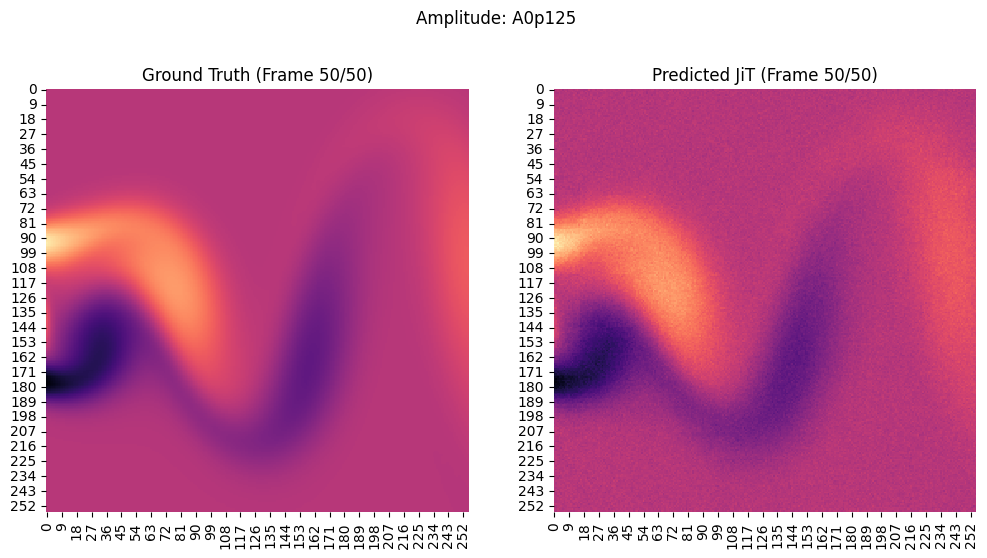

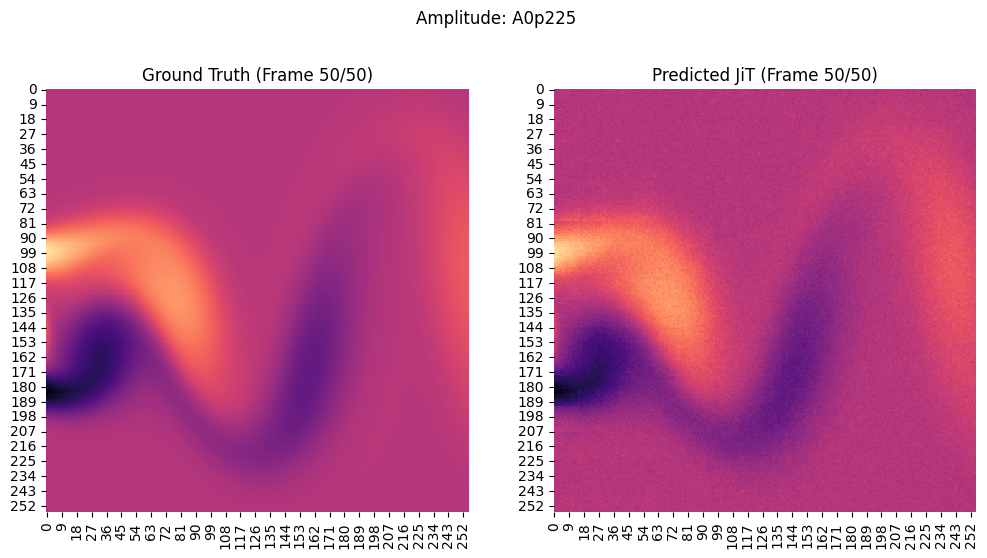

In [11]:
from tqdm import tqdm

# Evaluate
print("\n=== Evaluation on test set ===")
model.load_state_dict(torch.load(f"output/exp_{exp_name}/models/best_jit_fluid_model.pth"))

total_mse = 0
# Utilisation de tqdm pour voir l'avancement global des cas de test
pbar = tqdm(enumerate(test_list), total=len(test_list), desc="📊 Evaluating test cases")

for i, test_case in pbar:
    # On met à jour la description de la barre avec l'amplitude actuelle
    pbar.set_description(f"📊 Case {i+1}/{len(test_list)} (Amp: {test_case['amplitude']})")
    
    pred_frames, true_frames, mse = evaluate_autoregressive(
        model, test_case, past_window, device, num_frames=50, 
        frame_mean=frame_mean, frame_std=frame_std, num_steps=50 
    )
    total_mse += mse
    
    # Video
    gt_seq = true_frames.squeeze(1)
    pred_seq = pred_frames.squeeze(1)
    
    video_path = f"output/exp_{exp_name}/videos"
    os.makedirs(video_path, exist_ok=True)
    
    # Optionnel : Tu peux ajouter un print spécifique ou laisser tqdm gérer
    save_file = os.path.join(video_path, f"jit_comparison_{test_case['amplitude']}.gif")
    create_comparison_video(gt_seq, pred_seq, test_case['amplitude'], save_path=save_file)
    
    # Affichage du MSE en temps réel dans la barre
    pbar.set_postfix(current_mse=f"{mse:.6f}")

avg_test_mse = total_mse / len(test_list)
print(f"\n{'='*60}")
print(f"✅ Average test MSE: {avg_test_mse:.6f}")
print(f"{'='*60}") 